# Codec

We're going to see if FSQ is a good fit for finding the tokens we need for our model. Basing ourselves on the work of Hertz-dev: https://github.com/Standard-Intelligence/hertz-dev/blob/main/tokenizer.py

In [31]:
import jax
import equinox as eqx
import equinox.nn as nn
import jax.numpy as jnp

class Upsample(eqx.Module):
    scale_factor:int
    mode:str
    
    def __init__(self, scale_factor, mode):
        self.scale_factor = scale_factor
        self.mode = mode
    
    @eqx.filter_jit
    def __call__(self, x):
        new_height = x.shape[1] * self.scale_factor
        return jax.image.resize(x, (x.shape[0], new_height), method=self.mode)
    
class ResBlock(eqx.Module):
    suite: nn.Sequential

    def __init__(self, channel, kernel_size:list=[3,1],compress:int=2, dilations:list=[2,1], bias=True, key=None):
        key1, key2, key3 = jax.random.split(key, 3)
        hidden = channel // compress
        self.suite = [nn.WeightNorm(nn.Conv1d(channel, hidden, kernel_size=kernel_size[0], dilation=dilations[0], use_bias=bias, padding="SAME",     padding_mode="REFLECT",key=key1))] +[
                    nn.WeightNorm(nn.Conv1d(hidden, hidden, kernel_size=kernel_size[i+1], use_bias=bias, dilation=dilations[i+1], padding="SAME",     padding_mode="REFLECT",key=k)) for i, k in enumerate(jax.random.split(key1, len(dilations[1:-1])))
                ] + [nn.WeightNorm(nn.Conv1d(hidden, channel, kernel_size=kernel_size[-1], dilation=dilations[-1], use_bias=bias, padding="SAME",    padding_mode="REFLECT", key=key3))]
                
    @eqx.filter_jit
    def __call__(self, x):
        out = x
        for unit in self.suite:
            out = jax.nn.elu(out)
            out = unit(out)
        return out
  
    
class DecodeResBloq(eqx.Module):
    res: ResBlock   
    conv: nn.ConvTranspose1d
    
    def __init__(self, chan_in, chan_out, stride, key=None):
        key0, key1 = jax.random.split(key)

        self.res = ResBlock(
            chan_in,
            bias=True,
            key=key1
        )
        self.conv = nn.WeightNorm(nn.ConvTranspose1d(                
            chan_in,
            chan_out,
            kernel_size=stride*2,
            stride=stride,
            padding="SAME",
            use_bias=True,
            key=key0
        ))
        
    @eqx.filter_jit
    def __call__(self, x):
        y = self.res(x) + x
        y = jax.nn.elu(y)
        return self.conv(y)
    
class ResBloq(eqx.Module):
    res: ResBlock   
    conv: nn.Conv1d
    
    def __init__(self, chan_in, chan_out, stride, key=None):
        key0, key1 = jax.random.split(key)

        self.res = ResBlock(
            chan_in,
            bias=True,
            key=key1
        )
        self.conv = nn.WeightNorm(nn.Conv1d(                
            chan_in,
            chan_out,
            kernel_size=stride*2,
            stride=stride,
            padding="SAME",
            padding_mode="REFLECT",
            use_bias=True,
            key=key0
        ))
        
    @eqx.filter_jit
    def __call__(self, x):
        y = self.res(x) + x
        y = jax.nn.elu(y)
        return self.conv(y)
    


class Encoder(eqx.Module):
    suite: list
    first_conv: nn.Conv1d
    
    def __init__(self, in_channels, hidden_channels, latent_channels, kernel_size=7, channel_ratios: tuple =(1,2,4,8,16),
                 strides:tuple=(2,4,5,8),key=None):
        key0, key1, key2 = jax.random.split(key, 3)
        self.first_conv = nn.WeightNorm(nn.Conv1d(
            in_channels,
            hidden_channels * channel_ratios[0],
            kernel_size=kernel_size,
            stride=1,
            padding="SAME",
            padding_mode="REFLECT",
            use_bias=True,
            key=key0,            
        ))
        self.suite =[ResBloq(hidden_channels * channel_ratios[idx], hidden_channels * channel_ratios[idx + 1], strides[idx], k) for idx, k in enumerate(jax.random.split(key1, len(strides)))
        ] +[nn.WeightNorm(nn.Conv1d(
            hidden_channels * channel_ratios[-1], latent_channels, kernel_size=kernel_size, padding="SAME", padding_mode="REFLECT",use_bias=True,key=key2
        ))]
        
    @eqx.filter_jit
    def __call__(self, x):
        out = self.first_conv(x)
        
        for unit in self.suite:
            out = unit(out)
            # jax.debug.print("{x}", x=out[0][:10])
            out = jax.nn.elu(out)

        return out



class Decoder(eqx.Module):
    first_conv: nn.ConvTranspose1d
    suite: list
    
    def __init__(self, in_channels, hidden_channels, latent_channels, kernel_size=7, channel_ratios: tuple =(16,8,4,2,1),
                 strides:tuple=(8,5,4,2),key=None):
        key0, key1, key2 = jax.random.split(key, 3)
        self.first_conv = nn.WeightNorm(nn.ConvTranspose1d(
             latent_channels, hidden_channels * channel_ratios[0], kernel_size=7, padding="SAME", use_bias=False, key=key2
        ))
        
        self.suite = [DecodeResBloq(hidden_channels * channel_ratios[idx], hidden_channels * channel_ratios[idx + 1], strides[idx], k) for idx, k in enumerate(jax.random.split(key1, len(strides)))
        ] +[nn.WeightNorm(nn.ConvTranspose1d(
            hidden_channels * channel_ratios[-1],
            in_channels,
            kernel_size=kernel_size,
            stride=1,
            padding="SAME",
            use_bias=False,
            key=key0,            
        ))]
        
    @eqx.filter_jit
    def __call__(self, x):
        out = self.first_conv(x)
        
        for unit in self.suite:
            out = unit(out)
            # jax.debug.print("{x}", x=out[0][:10])
            out = jax.nn.elu(out)

        return out


In [32]:
x = jax.random.normal(key=jax.random.key(1), shape=(1, 16000))
enc = Encoder(1, 4, 1, 5, key=jax.random.key(1))
dec = Decoder(1, 4, 1, 5, key=jax.random.key(1))

y = enc(x)
z = dec(y)

print(x.shape)
print(y.shape)
print(z.shape)

KeyboardInterrupt: 

We take the code from the google repo for the FSQ.

In [ ]:

Codeword = jax.Array
Indices = jax.Array


class FSQ(eqx.Module):
    """Quantizer, taken from https://github.com/google-research/google-research/blob/master/fsq/fsq.ipynb"""

    _levels: list[int]
    _levels_np: jax.Array
    _eps: float
    _basis: jax.Array
    _implicit_codebook: jax.Array

    def __init__(self, levels: list[int], eps: float = 1e-3):
        self._levels = levels
        self._eps = eps
        self._levels_np = jnp.asarray(levels)
        self._basis = jnp.concatenate(
            (jnp.array([1]), jnp.cumprod(self._levels_np[:-1]))
        )

        self._implicit_codebook = self.indexes_to_codes(jnp.arange(self.codebook_size))

    @property
    def num_dimensions(self) -> int:
        """Number of dimensions expected from inputs."""
        return len(self._levels)

    @property
    def codebook_size(self):
        """Size of the codebook."""
        return jnp.prod(jnp.array(self._levels))

    @property
    def codebook(self):
        """Returns the implicit codebook. Shape (prod(levels), num_dimensions)."""
        return self._implicit_codebook

    @eqx.filter_jit
    def round_ste(self, z):
        """Round with straight through gradients."""
        zhat = jnp.round(z)
        return z + jax.lax.stop_gradient(zhat - z)

    @eqx.filter_jit
    def bound(self, z: jax.Array) -> jax.Array:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels_np - 1) * (1 - self._eps) / 2
        offset = jnp.where(self._levels_np % 2 == 1, 0.0, 0.5)
        shift = jnp.tan(offset / half_l)
        return jnp.tanh(z + shift) * half_l - offset

    @eqx.filter_jit
    def __call__(self, z: jax.Array) -> Codeword:
        """Quanitzes z, returns quantized zhat, same shape as z."""
        quantized = self.round_ste(self.bound(z))

        # Renormalize to [-1, 1].
        half_width = self._levels_np // 2
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized):
        # Scale and shift to range [0, ..., L-1]
        half_width = self._levels_np // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat):
        half_width = self._levels_np // 2
        return (zhat - half_width) / half_width

    def codes_to_indexes(self, zhat: Codeword) -> Indices:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.num_dimensions
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(axis=-1).astype(jnp.uint32)

    def indexes_to_codes(self, indices: Indices) -> Codeword:
        """Inverse of `indexes_to_codes`."""
        indices = indices[..., jnp.newaxis]
        codes_non_centered = jnp.mod(
            jnp.floor_divide(indices, self._basis), self._levels_np
        )
        return self._scale_and_shift_inverse(codes_non_centered)


class VQVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    quantizer: FSQ

    def __init__(self, in_channels, hidden_channels, latent_channels, levels, key=None):
        key1, key2 = jax.random.split(key)

        self.encoder = Encoder(in_channels, hidden_channels, latent_channels, key=key1)
        self.decoder = Decoder(in_channels, hidden_channels, latent_channels, key=key2)
        self.quantizer = FSQ(levels=levels)
        print("✅ Model initialized")

    @eqx.filter_jit
    def __call__(self, x):
        
        z_e = self.encoder(x)
        # reshaped_z_e = jnp.reshape(z_e, (-1, 10)) #16000 Hz -> 16Hz = 1000 points per code downsampled from 1000 to 5. Map each set of 5 to their respective code and map back. There are 4 levels thus 5 * (2 ** 4) = 80bits per codeword
        # reshaped_z_q = self.quantizer(reshaped_z_e)
        # z_q = jnp.reshape(reshaped_z_q, z_e.shape)
        y = self.decoder(z_e)
        return y

In [ ]:
x = jax.random.normal(key=jax.random.key(0), shape=(1, 16000))
model = VQVAE(1, 4, 1, [4], key=jax.random.key(4))
y = model(x)
z = model.encoder(x)
print(x.shape)
print(y.shape)
print(z.shape)

✅ Model initialized
(1, 16000)
(1, 16000)
(1, 50)


Let's train it and see what results we get !

In [ ]:
import optax
from tensorboardX import SummaryWriter
from datasets import load_dataset
import datetime
import time

import jax
import jax.tree_util as jtu
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
key1, key2 = jax.random.split(jax.random.key(1), 2)

model = VQVAE(1, 32, 1, [4], key=key1)

def init_weights(path, x):
    global key1
    k, key1 = jax.random.split(key1)
    if "weight" in jtu.keystr(path):
        print(path)
        return jax.nn.initializers.xavier_uniform()(k, x.shape)
    elif "bias" in jtu.keystr(path):
        return jax.nn.initializers.constant(0)(k, x.shape)
    return x

model = jtu.tree_map_with_path(init_weights, model)

optimizer = optax.chain(
  optax.clip(1.0),
  optax.adam(8e-4, 0.5, 0.9),
)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
step = 0

dataset = load_dataset("blabble-io/libritts_r", "clean", streaming=True)

def cut_up(samples):
    list = []
    for sample in samples["audio"]:
        resampled = librosa.resample(sample["array"], orig_sr=22050, target_sr=16000)
        for i in range(0, (int(len(resampled)//8000) -1)):
            list.append(resampled[i*8000:i*8000+8000])
    return {"audio": list}

dataset = dataset.map(cut_up, batched=True, remove_columns=['text_normalized', 'text_original', 'speaker_id', 'path', 'chapter_id', 'id'])


✅ Model initialized
(GetAttrKey(name='encoder'), GetAttrKey(name='suite'), SequenceKey(idx=0), GetAttrKey(name='res'), GetAttrKey(name='suite'), SequenceKey(idx=0), GetAttrKey(name='layer'), GetAttrKey(name='weight'))
(GetAttrKey(name='encoder'), GetAttrKey(name='suite'), SequenceKey(idx=0), GetAttrKey(name='res'), GetAttrKey(name='suite'), SequenceKey(idx=1), GetAttrKey(name='layer'), GetAttrKey(name='weight'))
(GetAttrKey(name='encoder'), GetAttrKey(name='suite'), SequenceKey(idx=0), GetAttrKey(name='conv'), GetAttrKey(name='layer'), GetAttrKey(name='weight'))
(GetAttrKey(name='encoder'), GetAttrKey(name='suite'), SequenceKey(idx=1), GetAttrKey(name='res'), GetAttrKey(name='suite'), SequenceKey(idx=0), GetAttrKey(name='layer'), GetAttrKey(name='weight'))
(GetAttrKey(name='encoder'), GetAttrKey(name='suite'), SequenceKey(idx=1), GetAttrKey(name='res'), GetAttrKey(name='suite'), SequenceKey(idx=1), GetAttrKey(name='layer'), GetAttrKey(name='weight'))
(GetAttrKey(name='encoder'), GetAtt

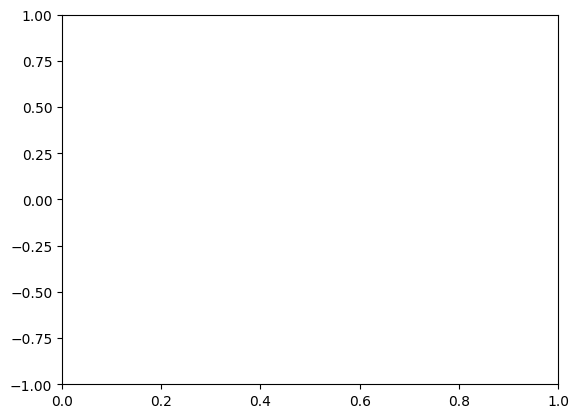

In [ ]:
# sphinx_gallery_thumbnail_number = 5
# sphinx_gallery_thumbnail_number = 5

import jax.experimental
from ott.geometry import pointcloud
from ott.tools import sinkhorn_divergence

batch_size = 128

dataloader= dataset["train.clean.360"].batch(batch_size=batch_size)

@eqx.filter_jit
def partialed(x, y):
    return sinkhorn_divergence.sinkhorn_divergence(
            pointcloud.PointCloud,
            x=x,
            y=y,
            epsilon=0.05,
        )[1].divergence

@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def calculate_losses(model, x):
    y = jax.vmap(model)(x)
    loss = jnp.mean(jax.vmap(partialed, in_axes=(0,0))(x, y))

    return jnp.mean((x-y)**2), (y, loss)


@eqx.filter_jit
def make_step(model, optimizer, opt_state, x):
    (total_loss, (y, wtf)), grads = (
        calculate_losses(model, x)
    )
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)

    return (
        model,
        opt_state,
        total_loss,
        grads,
        y,
         wtf
    )
    
key = jax.random.key(3)
    
fig, ax = plt.subplots(1)
ax.set_ylim(-1.0, 1.0)  # Adjust based on the expected range of your data

# fig.show()
step = 0


In [ ]:


for epoch in range(epochs):
    # eqx.tree_serialise_leaves(f"checkpoints/{epoch}.eqx", model)
    for batch in dataloader:
        input = jnp.expand_dims(jnp.array(batch["audio"]), 1)
        model, opt_state, total_loss, grads, y, wtf = make_step(model, optimizer, opt_state, input)

        # Log codebook updates to TensorBoard
        writer.add_scalar('Loss/MSE', total_loss, step)
        writer.add_scalar('Loss/Sinkhorn', wtf, step)
        # time.sleep(3)
        step+=1
        if (step // batch_size) % 100 == 0:
            ax.clear()
            ax.plot(batch["audio"][0])
            ax.plot(y[0][0])
            ax.set_ylim(-1.0, 1.0)  # Adjust based on the expected range of your data
            display(fig)
            clear_output(wait=True)
    # plt.imshow(y[0])otal_loss}")

KeyboardInterrupt: 

In [ ]:
eqx.tree_serialise_leaves("checkpoints/fsq.eqx", model)

In [ ]:


model = eqx.tree_deserialise_leaves("checkpoints/fsq.eqx", model)


In [33]:
data = iter(dataloader)

In [40]:
import numpy as np
import IPython 

sample = next(data)["audio"][0]
IPython.display.Audio(sample, rate=16000)


In [41]:

y = model(jnp.expand_dims(sample,0))
z = model.encoder(jnp.expand_dims(sample, 0))
codes = model.quantizer.codes_to_indexes(jnp.expand_dims(model.quantizer(z), -1))
print(codes)

IPython.display.Audio(y, rate=16000)

[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [ ]:
len(codes[0])

25

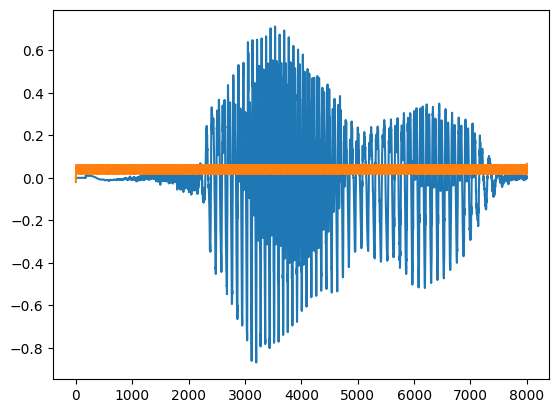

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(sample)
ax.plot(y[0])
fig.show()

In [ ]:
# sphinx_gallery_thumbnail_number = 5

import torch
import matplotlib.pylab as pl
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss
import jax
import numpy as np

loss = SamplesLoss(loss="sinkhorn", p=1, blur=.05)

test = jax.random.normal(jax.random.key(1), shape=(1,100))
test2 = jax.random.normal(jax.random.key(3), shape=(1,100))


a = torch.from_numpy(np.array(test))
b = torch.from_numpy(np.array(test2))

L = loss(a, b)
print(L)


In [ ]:
from ott.geometry import pointcloud
from ott.solvers import linear
from ott.geometry.costs import EuclideanP
from ott.tools import plot, sinkhorn_divergence

# print(sample.shape)
# print(y[0].shape)
# a= jnp.stack([sample, jnp.arange(0, sample.shape[-1])])
# b= jnp.stack([y[0], jnp.arange(0, y.shape[-1])])
# print(a.shape)
# print(b.shape)
# geom = pointcloud.PointCloud(jnp.transpose(a), jnp.transpose(b),epsilon=10,cost_fn=EuclideanP(2))
# solve_fn = jax.jit(linear.solve)
test = jax.random.normal(jax.random.key(1), shape=(1,100))
test2 = jax.random.normal(jax.random.key(1), shape=(1,100))*0.9
# ot = solve_fn(geom)
print(sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud,
        x=jnp.expand_dims(sample, 0),
        y=y,
        epsilon=0.05,
    )[1].divergence)
# print(f"OT Cost, lower bound = {ot.dual_cost:3f}, upper = {ot.primal_cost:3f}")

In [ ]:
from ott.geometry import pointcloud
from ott.solvers import linear
from ott.geometry.costs import EuclideanP

print(sample.shape)
print(y[0].shape)
a= jnp.stack([sample, jnp.arange(0, sample.shape[-1])])
b= jnp.stack([y[0], jnp.arange(0, y.shape[-1])])
print(a.shape)
print(b.shape)
geom = pointcloud.PointCloud(jnp.transpose(a), jnp.transpose(b),epsilon=10,cost_fn=EuclideanP(2))
solve_fn = jax.jit(linear.solve)
ot = solve_fn(geom)
print(f"OT Cost, lower bound = {ot.dual_cost:3f}, upper = {ot.primal_cost:3f}")

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

P = ot.matrix
plt.imshow(P[:100, :100], cmap="Purples")
plt.colorbar()

In [ ]:
print(ot.reg_ot_cost)

In [ ]:
eqx.tree_serialise_leaves("checkpoints/fsq.eqx", model)